# BERT base uncased, soma dos score do par.

## HypeNET - Train
- pré-processado para não ter palavras compostas
- (1,1) é um par onde hipônimo e hiperônimo são de tamanho 1
- O tamanho do par (1,1) será 2, assim como o tamanho do par (2,1) e (1,2) será 3

> Suponha o par (3,2) (abacate, fruta)
> Temos as seguintes sentenças:
- [MASK] ca te é um tipo de fru ta
- aba [MASK] te é um tipo de fru ta
- aba ca [MASK] é um tipo de fru ta
- aba ca te é um tipo de [MASK] ta
- aba ca te é um tipo de fru [MASK]

> Mascarando a palavra e pegando o score dela. O score pra esse par será a soma de todos os valores recuperados.


In [7]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os
import nb_utils


sns.set(style="whitegrid")
plt.clf()
method_names = {'word2vec': 'Word2vec C', 'summation_dot_product': 'DIVE \u0394S * C ', 'dot_product': 'DIVE C',
                'rnd': 'random', 'summation': 'DIVE \u0394S', 'summation_word2vec': 'DIVE \u0394S * Word2vec C',
                'all_subword mean_positional_rank': 'BERT Mean Pos Rank', 'all_subword min_positional_rank': 'BERT Min Pos Rank',
                'all_subword max_pattern': 'BERT Max Pattern', 'all_subword mean_pattern': 'BERT Mean Pattern',
                'min score_final_log(z)': 'BERT Min Pos Rank (log(z))', 'min score_final_norm': 'BERT Min Pos Rank (/ norm)',
                'mean score_final_log(z)': 'BERT Mean Pos Rank (log(z))', 'mean score_final_norm': 'BERT Mean Pos Rank (/ norm)'}

vocabs = ["../vocabs/wikipedia15M/vocab.txt",
          "../vocabs/wikipedia30M/vocab.txt",
          "../vocabs/wikipedia60M/vocab.txt",
          "../vocabs/wikipedia120M/vocab.txt",
          "../vocabs/wikipedia240M/vocab.txt"]
# path_d_w = ["/home/gabrielescobar/Documentos/dive-pytorch/results/wikipedia-datasets-test/wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_not_oov/_result_models_model-wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_dataset_.-datasets.tsv",
#             "/home/gabrielescobar/Documentos/dive-pytorch/results/wikipedia-datasets-test/wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX/_result_models_model-wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_dataset_.-datasets.tsv"]

# data
#server
path_file_bert = "../../en-model/bert-base-uncased-train/train_simples.json"
json_data = json.load(open(path_file_bert))

df_with_oov = nb_utils.create_dataframe(json_data)


pattern_unique = df_with_oov['pattern'].unique().tolist()
len_total_unique = df_with_oov['len_total'].unique().tolist()

print(f"DF all with OOV = {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]].count()['hiponimo']}")

# df com oov
df_with_oov = nb_utils.logsumexp_normalization(df_with_oov, len_list=len_total_unique, pattern_list=pattern_unique)

DF all with OOV = 36759


<Figure size 432x288 with 0 Axes>

## Balanceamento do Dataset e AP por padrão
#### Todo dataset
 - N = 36759 pares

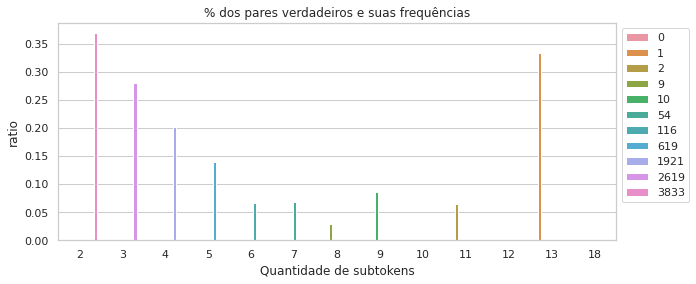

In [8]:
# Balanceamento df_with_oov
df_with_oov_ratio = nb_utils.balanceamento(df_with_oov, patterns=pattern_unique,len_size=len_total_unique)

plt.figure(figsize=(10, 4))
ax = sns.barplot(x="len_total", y="ratio", hue="true", data=df_with_oov_ratio)
ax.set(xlabel="Quantidade de subtokens")
ax.set_title(f"% dos pares verdadeiros e suas frequências")
ax.legend(bbox_to_anchor=(1, 1))

_ = _

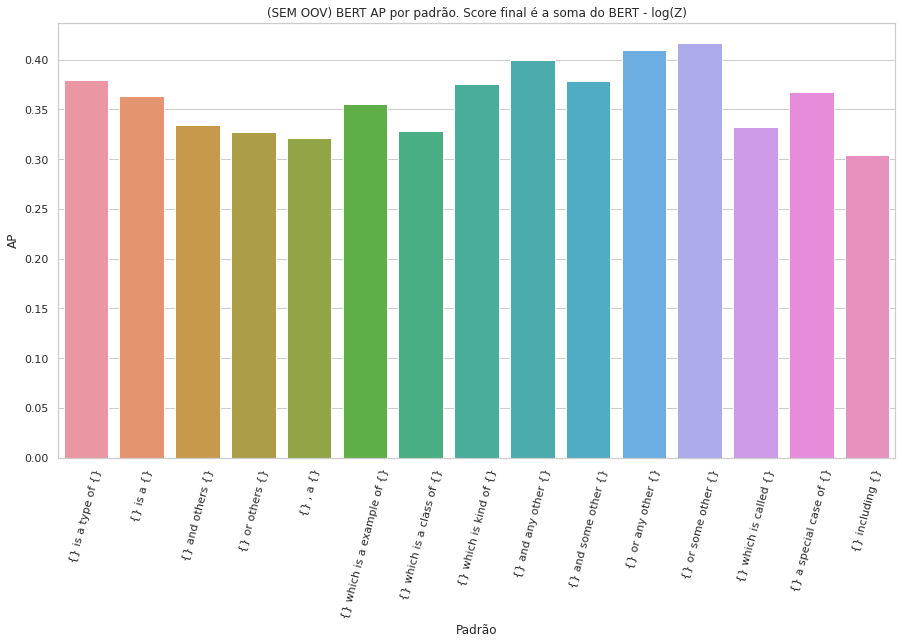

Melhores padrões usando score_final_log(Z)
['{} or some other {}', '{} or any other {}', '{} and any other {}', '{} is a type of {}', '{} and some other {}', '{} which is kind of {}', '{} a special case of {}', '{} is a {}', '{} which is a example of {}', '{} and others {}', '{} which is called {}', '{} which is a class of {}', '{} or others {}', '{} , a {}', '{} including {}']


In [9]:
# AP por padrão
df_plot = nb_utils.compute_dataframe_AP_by_pattern(df_with_oov, key_sort="score_final_log(z)", pattern_list=pattern_unique)
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=df_plot, x='padrao', y='AP')
ax.set(xlabel="Padrão")
ax.set_title(f"BERT AP por padrão. Score final é a soma do BERT - log(Z)")
plt.xticks(rotation=75)
plt.show()

print(f"Melhores padrões usando score_final_log(Z)")
best_pattern_logz = df_plot.sort_values(by='AP', ascending=False)['padrao'].tolist()
print(best_pattern_logz)

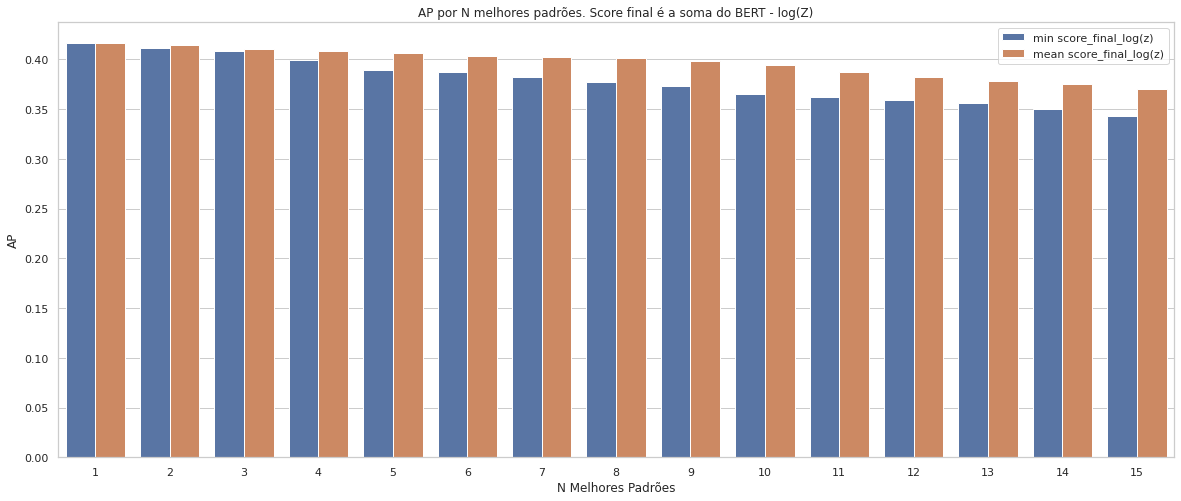

In [10]:
# AP por n-rank
df_plot = nb_utils.compute_AP_n_best_pattern(df_with_oov, key_sort="score_final_log(z)", n_best_pattern=best_pattern_logz)
plt.figure(figsize=(20, 8))
ax = sns.barplot(data=df_plot, x='n_best_pattern', y='AP', hue='method')
ax.set(xlabel="N Melhores Padrões")
ax.set_title(f"AP por N melhores padrões. Score final é a soma do BERT - log(Z)")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [11]:
df_mean = df_plot[df_plot['method'] == 'mean score_final_log(z)']
df_mean = df_mean.sort_values(by='AP', ascending=False)
print(f"Melhor combinação de Melhores Padrões usando Média dos ranks entre eles")
print(df_mean.iloc[:4])

print(f"Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles")
df_min = df_plot[df_plot['method'] == 'min score_final_log(z)']
df_min = df_min.sort_values(by='AP', ascending=False)
print(df_min.iloc[:4])

Melhor combinação de Melhores Padrões usando Média dos ranks entre eles
   n_best_pattern                   method        AP
1               1  mean score_final_log(z)  0.416332
3               2  mean score_final_log(z)  0.414576
5               3  mean score_final_log(z)  0.410417
7               4  mean score_final_log(z)  0.408763
Melhor combinação de Melhores Padrões usando Minimo dos ranks entre eles
   n_best_pattern                  method        AP
0               1  min score_final_log(z)  0.416332
2               2  min score_final_log(z)  0.410988
4               3  min score_final_log(z)  0.408446
6               4  min score_final_log(z)  0.398894
